In [1]:
import json 
import pandas as pd
import seaborn as sns
import os
import gc
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  cm
import cv2
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import rasterio as rio
import numpy as np
import imageio

In [2]:
model = tf.keras.models.load_model('C:/1_flood hawk\CNN_models\SAR_CNN.h5')

c:\1_flood hawk\myvenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [3]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_1[0][0]     │
│ (ZeroPadding2D)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      6,336 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 24,622,020 (93.93 MB)

 Trainable params: 24,571,458 (93.73 MB)

 Non-trainable params: 50,560 (197.50 KB)

 Optimizer params: 2 (12.00 B)

In [4]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [6]:
def model_modifier_function(cloned_model):
    '''modify model activation'''
    cloned_model.layers[-1].activation = tf.keras.activations.linear

def get_saliency(img, score, cnn_model):
    img = img.astype(np.float32)
    saliency = Saliency(cnn_model, model_modifier=model_modifier_function, clone=True)
    sal_map = saliency(score, img, smooth_samples=20, smooth_noise=0.20)
    return sal_map.squeeze(axis=0)  # Remove batch dimension


# Grad-CAM
def get_gradcam(img, score, cnn_model):
    gradcam = Gradcam(cnn_model, model_modifier=model_modifier_function, clone=True)
    cam = gradcam(score, img, seek_penultimate_conv_layer=True)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)  # Convert to RGB heatmap
    return heatmap


# Grad-CAM++
def get_gradcam_plus(img, score, cnn_model):
    gradcam_plus = GradcamPlusPlus(cnn_model, model_modifier=ReplaceToLinear(), clone=True)
    cam = gradcam_plus(score, img)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)  # Convert to RGB heatmap
    return heatmap



In [7]:
def preprocess_image(file_path, model_type):
    """Preprocess images for SAR, S2, or RGB model types."""


    def read_raster(file_path):
        """Read .tif file using rasterio."""
        with rio.open(file_path) as f:
            return f.read(1)  # Read the first band

    # List all .tif files in the given directory
    images = [os.path.join(file_path, fname) for fname in os.listdir(file_path) if fname.endswith('.tif')]
    if not images:
        raise ValueError(f"No .tif files found in {file_path} for model type {model_type}.")
    
    if model_type == 'SAR':
        # Expect two bands: VH and VV
        if len(images) < 2:
            raise ValueError(f"Not enough images for SAR data. Expected 2, found {len(images)}.")
        images = sorted(images)  # Ensure correct order
        
        vh = read_raster(images[0]) / 50.0  # Normalize using SAR-specific scaling
        vv = read_raster(images[1]) / 100.0
        
        image = np.stack([vh, vv], axis=-1)
        image = cv2.resize(image, (256, 256))
        return image

    elif model_type == 'S2':
        bands = []
        for band_file in sorted(images):  # Ensure order
            band = read_raster(band_file) / 10000.0  # Normalize
            band = cv2.resize(band, (256, 256))
            bands.append(band)
        if len(bands) != 12:  # Ensure correct raster count
            raise ValueError(f"Expected 12 bands for S2 data, found {len(bands)}.")
        return np.stack(bands, axis=-1)

    elif model_type == 'RGB':
        required_bands = ['B02', 'B03', 'B04']
        band_files = {band: next((f for f in images if band in os.path.basename(f)), None) for band in required_bands}
        missing_bands = [band for band, f in band_files.items() if f is None]
        if missing_bands:
            raise ValueError(f"Missing required bands for RGB: {', '.join(missing_bands)}")

        rgb_bands = []
        for band_file in band_files.values():
            band = read_raster(band_file) / 10000.0  # Normalize for RGB bands
            band = cv2.resize(band, (256, 256))
            rgb_bands.append(band)
        return np.stack(rgb_bands, axis=-1)

    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [9]:
def predict(file_path, model_type):
    """Make prediction on the uploaded image and generate heatmap."""
    # Load and preprocess the image
    image = preprocess_image(file_path, model_type)
    image = image.astype(np.float32)
    
    # Load the model
    
    
    # Make prediction
    pred = model.predict(image[None, ...])  # Add batch dimension
    model_prediction = np.argmax(pred, axis=-1)[0]  # 0: No Flooding, 1: Flooded
    score = CategoricalScore(model_prediction)
    # Generate the heatmap
    saliency_map_img = get_saliency(image[None, ...], score, model)
    grad_cam_img = get_gradcam(image[None, ...], score, model)
    grad_cam_plus_img = get_gradcam_plus(image[None, ...], score, model)

    return model_prediction, saliency_map_img, grad_cam_img, grad_cam_plus_img, image


In [10]:
file_path1 = "C:/1_flood hawk/app/uploads/sen12floods_s1_source_0212_2019_03_31/sen12floods_s1_source_0212_2019_03_31"
model_type = "SAR"

In [11]:
model_prediction, saliency_map_img, grad_cam_img, grad_cam_plus_img, original_img = predict(file_path1, model_type.upper())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\1_flood hawk\myvenv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_1. Received: the structure of inputs=['*']
  warnings.warn(


In [21]:
print(os.listdir(file_path1))

['sen12floods_s1_source_0212_2019_03_31']


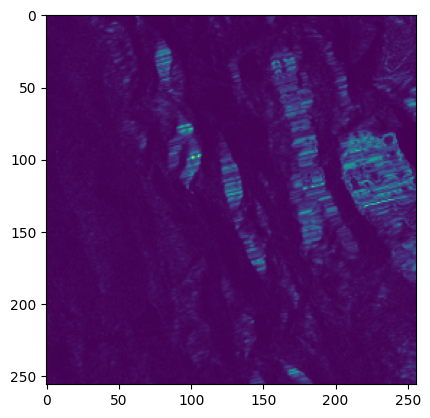

In [12]:
plt.imshow(original_img[:,:,1])

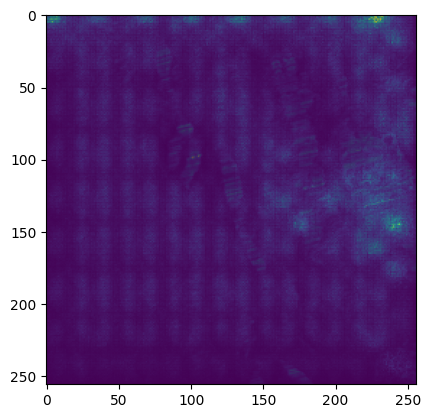

In [14]:
plt.imshow(original_img[:,:,1])
plt.imshow(saliency_map_img,alpha=0.75,cmap='viridis')

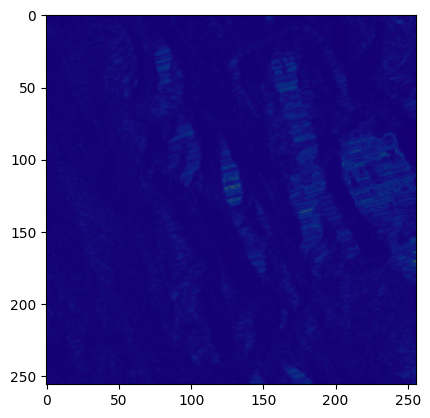

In [79]:
plt.imshow(original_img[:,:,0])
plt.imshow(grad_cam_plus_img,alpha=0.70,cmap='jet')

In [59]:
print(type(original_img))

<class 'numpy.ndarray'>


In [63]:
print(original_img[:,:,1])


[[0.00133546 0.00107263 0.00088257 ... 0.00355545 0.00410472 0.00337352]
 [0.0008405  0.00071904 0.00104899 ... 0.00270765 0.00378324 0.0046037 ]
 [0.0008321  0.00079719 0.00110539 ... 0.00559019 0.00424435 0.00470601]
 ...
 [0.00090143 0.00116754 0.00090892 ... 0.00688701 0.00837434 0.00877882]
 [0.00082848 0.00124569 0.00162699 ... 0.00242083 0.00370625 0.00495868]
 [0.00062718 0.00123734 0.00135774 ... 0.00390971 0.00486137 0.00560083]]


<Axes: >

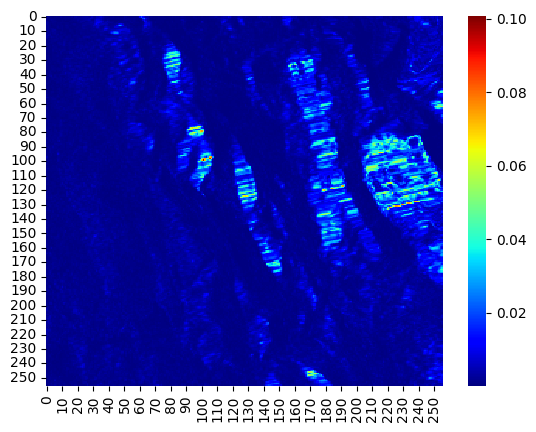

In [87]:
sns.heatmap(original_img[:,:,1], cmap='jet')